## Wrapped normal mixture for all curvatures

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay

from geomstats.geometry.hyperbolic import Hyperbolic
from geomstats.geometry.hypersphere import Hypersphere

from hyperdt.tree import HyperbolicDecisionTreeClassifier
from hyperdt.QC_wrapped_normal_all_curvatures import wrapped_normal_all_curvature

### Gaussian mixture in Euclidean space

In [29]:
# Generate Gaussian mixture data in Euclidean space
X, y, means = wrapped_normal_all_curvature(num_points=1000, num_classes=4, noise_std=0.3, seed=2, curvature=0.0)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train decision tree classifier
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

# Predict test set labels
y_pred = dtc.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.89


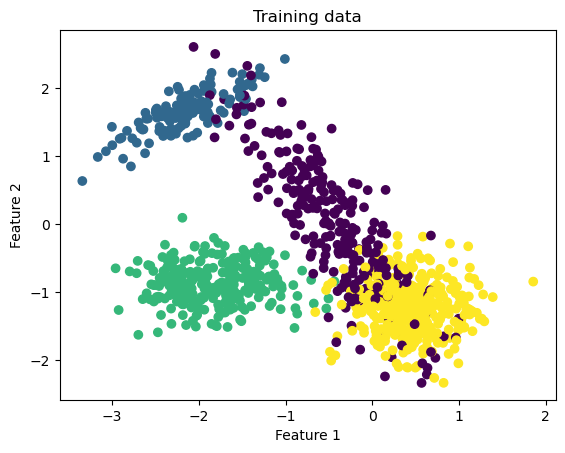

In [30]:
# Plot data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Training data')
plt.show()

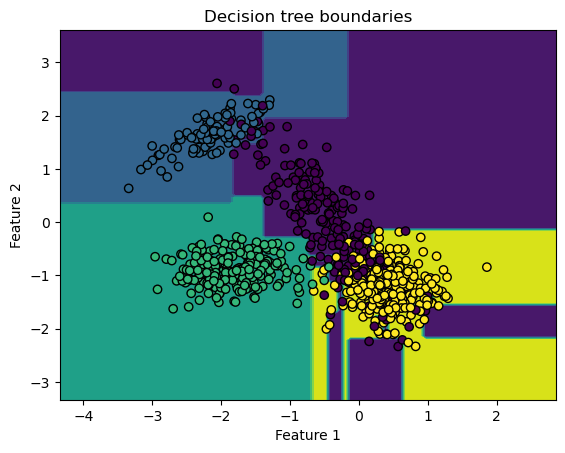

In [31]:
# Plot decision tree boundaries with training data
fig, ax = plt.subplots()
dbd = DecisionBoundaryDisplay.from_estimator(dtc, X_train, ax=ax)
dbd.plot(ax=ax)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision tree boundaries')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolor='k')
plt.show()

### Gaussian mixture in hyperbolic space

In [32]:
# Generate Gaussian mixture data in hyperbolic space
curvature = -2.0
X, y, means = wrapped_normal_all_curvature(num_points=1000, num_classes=4, noise_std=0.3, seed=2, curvature=curvature)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit hyperbolic decision tree classifier
hdt = HyperbolicDecisionTreeClassifier(timelike_dim=0, max_depth=2, curvature=curvature)
hdt.fit(X_train, y_train)

# Compute accuracy
hdt_score = hdt.score(X_test, y_test)
print(hdt_score)

0.755


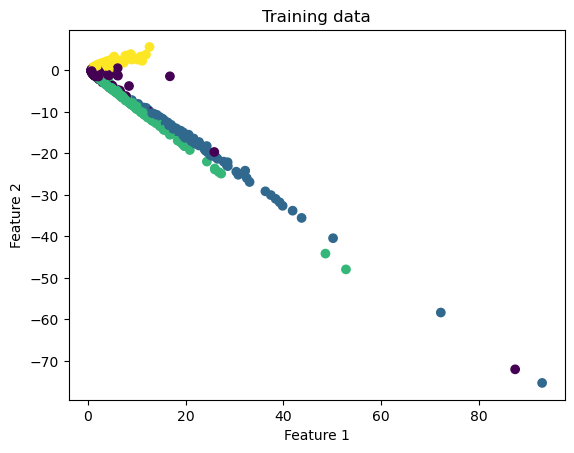

In [33]:
# Plot data in Euclidean space
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Training data')
plt.show()

### Gaussian mixture in hyperspherical space

In [34]:
# Modified decision tree classifier for hypersphere data
class HypersphereDecisionTreeClassifier(HyperbolicDecisionTreeClassifier):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _validate_hyperbolic(self, X):
        # Basically just skip the check
        pass

    def _get_candidates(self, X, dim):
        # Consider tangents
        thetas = np.arctan2(X[:, self.timelike_dim], X[:, dim])
        thetas = np.unique(thetas)  # This also sorts
        candidates = (thetas[:-1] + thetas[1:]) / 2
        return candidates

In [35]:
# Generate Gaussian mixture data in hyperspherical space
curvature = 2.0
X, y, means = wrapped_normal_all_curvature(num_points=1000, num_classes=4, noise_std=0.3, seed=2, curvature=curvature)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit hyperbolic decision tree classifier
hsdt = HypersphereDecisionTreeClassifier(max_depth=2, curvature=curvature)
hsdt.fit(X_train, y_train)

# Compute accuracy
hsdt_score = hsdt.score(X_test, y_test)
print(hsdt_score)

0.645


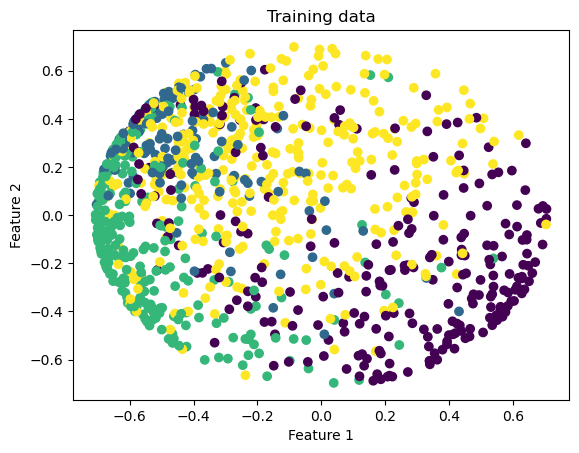

In [36]:
# Plot data in Euclidean space
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Training data')
plt.show()

### Plot distributions of distances from class means for different curvatures

In [37]:
def Minkowski_dot_product(v1, v2):
    return v1 @ v2 - 2 * v1[0] * v2[0]

In [38]:
# Generate Gaussian mixture data in a range of curvatures
curvatures = [-10.0, -1.0, -0.1, 0.0, 0.1, 1.0, 10.0]
data_by_curvature = []
for curvature in curvatures:
    X, y, means = wrapped_normal_all_curvature(num_points=1000, num_classes=4, noise_std=0.3, seed=2, curvature=curvature)
    data_by_curvature.append((X, y, means))

In [41]:
# Compute distances to class means
dists_by_curvature = []
for i in range(len(curvatures)):
    X, y, means = data_by_curvature[i]
    dists = []
    for x, idx in zip(X, y):
        class_mean = means[idx]
        if curvatures[i] < 0:
            dists.append(np.arccosh(curvatures[i] * Minkowski_dot_product(x, class_mean)) / np.sqrt(abs(curvatures[i])))
        elif curvatures[i] > 0:
            dists.append(np.arccos(curvatures[i] * np.dot(x, class_mean)) / np.sqrt(abs(curvatures[i])))
        else:
            dists.append(np.linalg.norm(x - class_mean))
    dists_by_curvature.append(dists)

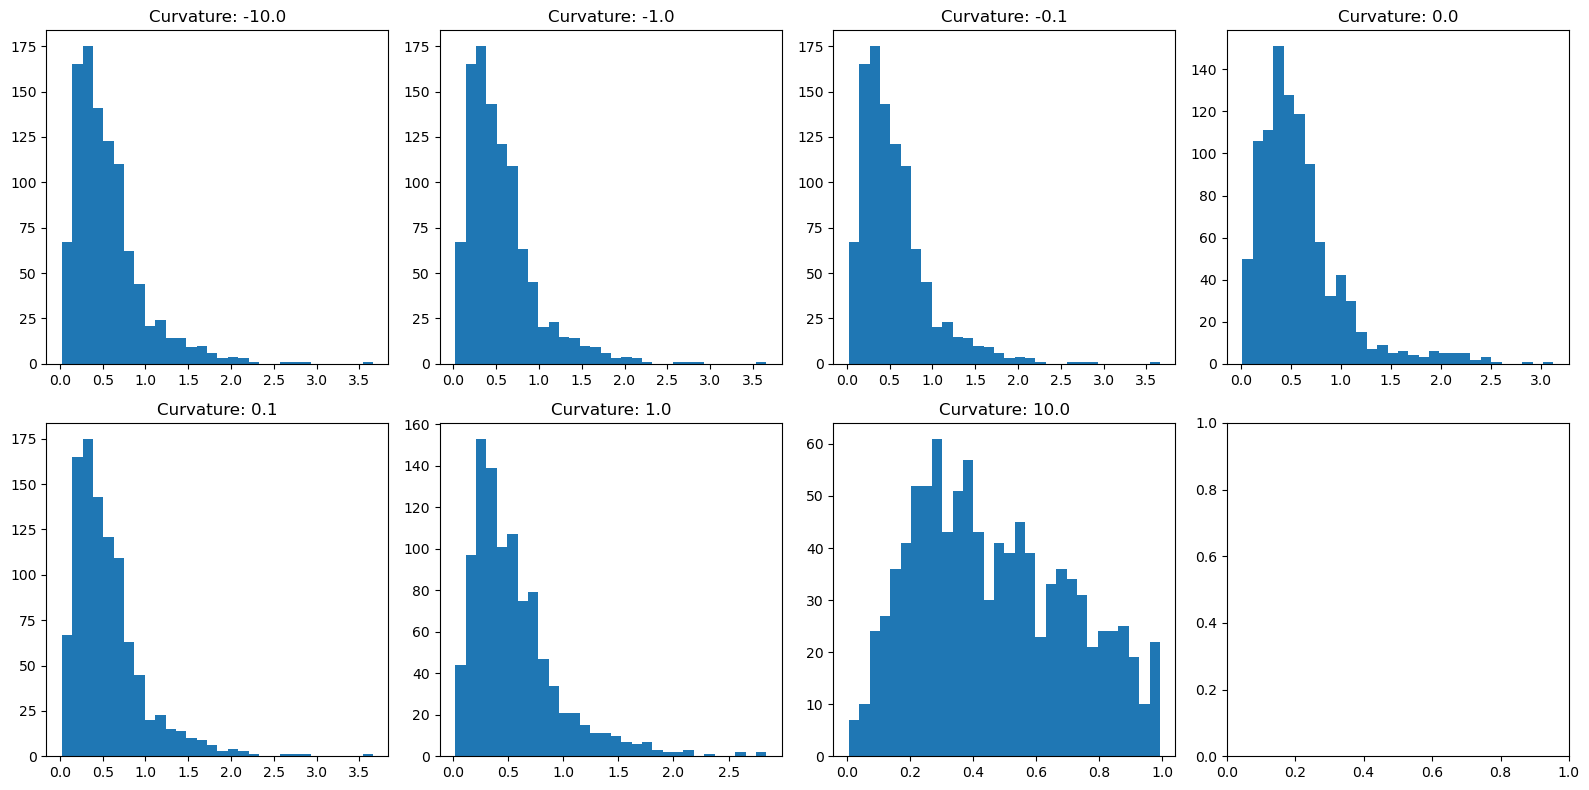

In [42]:
# Histograms of distances to class means in subplots
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for i in range(len(curvatures)):
    ax = axs[i // 4, i % 4]
    ax.hist(dists_by_curvature[i], bins=30)
    ax.set_title(f'Curvature: {curvatures[i]}')
plt.tight_layout()
plt.show()